# Laboratorio 8

Mario José Felix Rojas 

C.C : 1017261080

In [6]:
# Import the necessary modules
import numpy as np
import tensorflow as tf
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

1. Para el dataset make a moon de sklearn, construir un modelo de una red neuronal con keras para clasificar los datos.

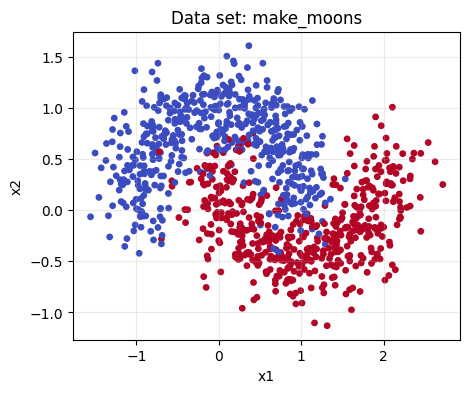

In [23]:
# Generar y visualizar los datos

# Aseguramos reproducibilidad
np.random.seed(42)

# Generamos los datos:
X, y =  make_moons(n_samples=1000, noise=0.25, random_state=42)

# Visualización de los datos
plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', s=15)
plt.title("Data set: make_moons")
plt.xlabel("x1"); plt.ylabel('x2')
plt.grid(alpha=0.25)
plt.show()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# estratificado para conservar proporciones de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

#  Validación (20% de lo que quedó para train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)

# Escalado: ajustar solo con train y aplicar a val/test
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Chequeo rápido
print("Shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)
print("Clases train:", np.bincount(y_train))
print("Clases val  :", np.bincount(y_val))
print("Clases test :", np.bincount(y_test))


Shapes: (640, 2) (160, 2) (200, 2)
Clases train: [320 320]
Clases val  : [80 80]
Clases test : [100 100]


In [25]:
# Paso 3.1: imports Keras/TensorFlow
import tensorflow as tf
from tensorflow import keras

# arquitectura (muy simple y efectiva para moons)
model = keras.Sequential([
    keras.layers.Input(shape=(2,)),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")   # salida binaria
])

# compilar (binary_crossentropy)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

# Detenemos antes para evitar sobreajuste
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# entrenamiento del modelo
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# evaluar en test
test_loss, test_acc, test_auc = model.evaluate(X_test_s, y_test, verbose=0)
print(f"Test — loss: {test_loss:.4f} | acc: {test_acc:.3f} | AUC: {test_auc:.3f}")


Test — loss: 0.0789 | acc: 0.970 | AUC: 0.997


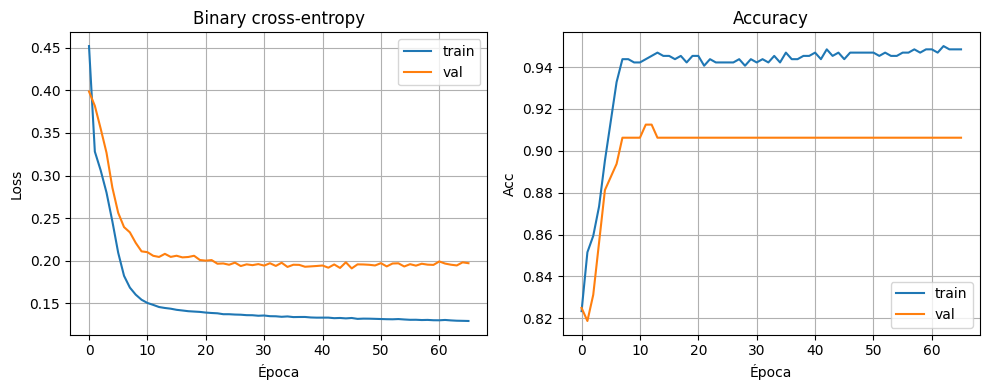

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


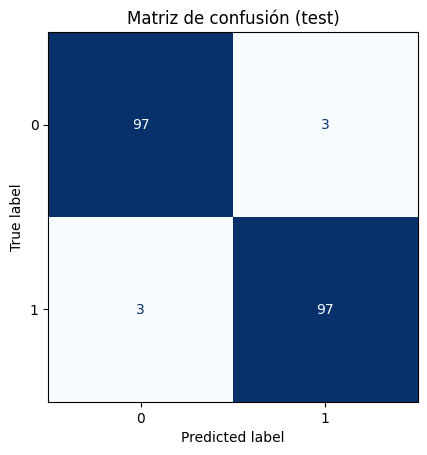

              precision    recall  f1-score   support

           0      0.970     0.970     0.970       100
           1      0.970     0.970     0.970       100

    accuracy                          0.970       200
   macro avg      0.970     0.970     0.970       200
weighted avg      0.970     0.970     0.970       200

2813/2813 ━━━━━━━━━━━━━━━━━━━━ 1s 231us/step


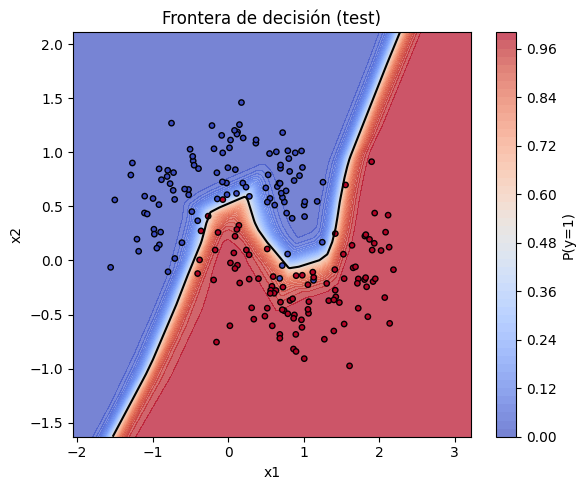

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Curvas de entrenamiento (loss y accuracy) 
hist = history.history

plt.figure(figsize=(10,4))
# Curva de pérdida (Loss)
plt.subplot(1,2,1)
plt.plot(hist["loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("Binary cross-entropy")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.legend()

# Curva de Accuracy
plt.subplot(1,2,2)
plt.plot(hist["accuracy"], label="train")
plt.plot(hist["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Época"); plt.ylabel("Acc"); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

#  Matriz de confusión y reporte 
y_prob = model.predict(X_test_s)
y_pred = (y_prob >= 0.5).astype(int).ravel()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues", colorbar=False)
plt.title("Matriz de confusión (test)")
plt.show()

print(classification_report(y_test, y_pred, digits=3))

# Frontera de decisión
# Malla en el espacio original (sin escalar)
x1_min, x1_max = X[:,0].min()-0.5, X[:,0].max()+0.5
x2_min, x2_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx, yy = np.meshgrid(
    np.linspace(x1_min, x1_max, 300),
    np.linspace(x2_min, x2_max, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]

# Transformar con el mismo scaler usado en train
grid_s = scaler.transform(grid)
zz = model.predict(grid_s).reshape(xx.shape)

plt.figure(figsize=(6,5))
# Probabilidades como fondo
cs = plt.contourf(xx, yy, zz, levels=50, cmap="coolwarm", alpha=0.7)
# Frontera de 0.5
plt.contour(xx, yy, zz, levels=[0.5], colors="k", linewidths=1.5)
# Puntos de test encima
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="coolwarm", s=15, edgecolor="k")
plt.title("Frontera de decisión (test)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.colorbar(cs, label="P(y=1)")
plt.tight_layout()
plt.show()


De la frontera de decisión, la curva separa bien las dos "lunas" y solo falla en la zona de solapamiento. Los "pliegues" cerca del centro son normales. 
La matriz de confusión asegura que el modelo corresponde muy bien a la forma en como se clasifican los datos.

2. Para el dataset load digits, construir un modelo de red neuronal empleando keras para realizar la clasificación

X_img shape: (1797, 8, 8)
X (flatten) shape: (1797, 64)
Clases: [0 1 2 3 4 5 6 7 8 9]


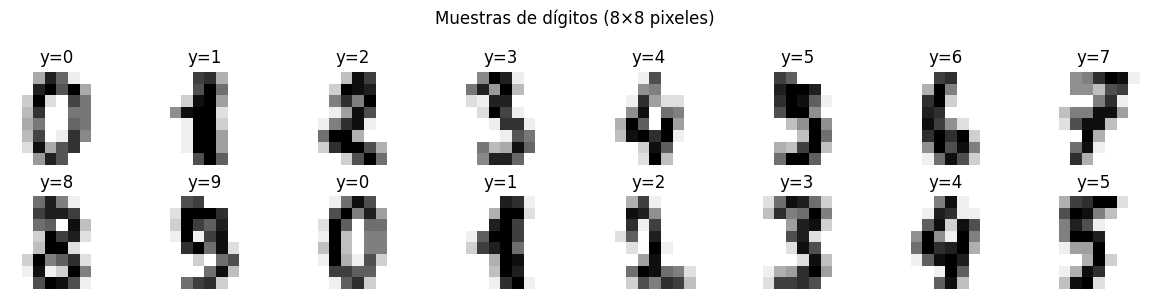

In [34]:
# Paso 1: carga y vista rápida del dataset "digits"
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# Reproducibilidad
np.random.seed(42)

# Cargar los datos
digits = load_digits()
X_img = digits.images            # imágenes 8x8 (n_samples, 8, 8)
y     = digits.target            # etiquetas 0..9 (n_samples,)
X     = digits.data              # mismo X pero "aplanado" (n_samples, 64)

print("X_img shape:", X_img.shape)   # (n, 8, 8)
print("X (flatten) shape:", X.shape) # (n, 64)
print("Clases:", np.unique(y))

# Visualizar algunas muestras
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for ax, i in zip(axes.ravel(), range(16)):
    ax.imshow(X_img[i], cmap="gray_r")
    ax.set_title(f"y={y[i]}")
    ax.axis("off")
plt.suptitle("Muestras de dígitos (8×8 pixeles)")
plt.tight_layout()
plt.show()


Sparación de los datos en datos de entrenamiento, de evaluación y escalado

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Train/Test (20% test), estratificado para mantener proporciones por dígito
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Validación (20% de lo que quedó para train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42, stratify=y_train
)

# Escalado 0–1 (pixels originales están en [0,16])
scaler = MinMaxScaler().fit(X_train)   # ¡solo con train!
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print(X_train_s.shape, X_val_s.shape, X_test_s.shape)


(1149, 64) (288, 64) (360, 64)


Definición del modelo, compilación y entrenamiento:

In [ ]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

# Arquitectura MLP para 10 clases
model = keras.Sequential([
    keras.layers.Input(shape=(64,)),                 # imágenes 8x8 "aplanadas"
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="softmax")     # salida multiclase
])

# Compilar: etiquetas enteras 0..9 → 'sparse_categorical_crossentropy'
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Early stopping (evitar sobreajuste y recuperar los mejores pesos)
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

# Entrenamiento del modelo
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

print("Épocas entrenadas:", len(history.history["loss"]))


Épocas entrenadas: 55


Evaluación en test

In [ ]:
test_loss, test_acc = model.evaluate(X_test_s, y_test, verbose=0)
print(f"Test — loss: {test_loss:.4f} | acc: {test_acc:.3f}")

Test — loss: 0.0546 | acc: 0.983


Presentamos curvas de entrenamiento, matriz de confusión y reporte

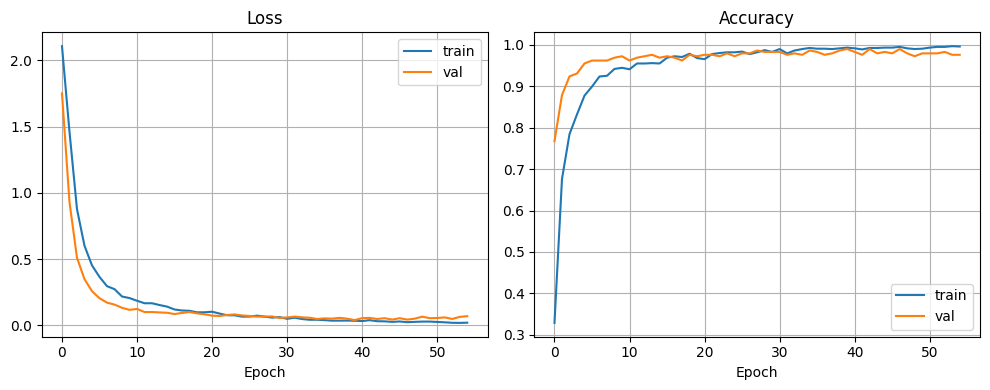

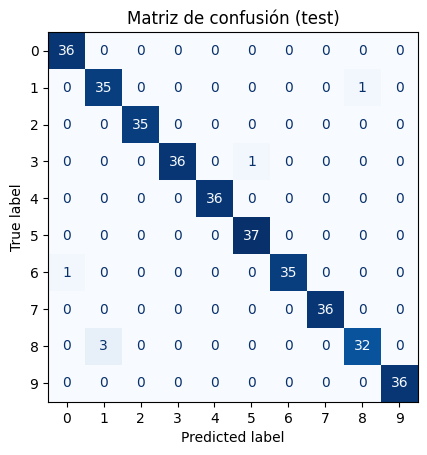

              precision    recall  f1-score   support

           0      0.973     1.000     0.986        36
           1      0.921     0.972     0.946        36
           2      1.000     1.000     1.000        35
           3      1.000     0.973     0.986        37
           4      1.000     1.000     1.000        36
           5      0.974     1.000     0.987        37
           6      1.000     0.972     0.986        36
           7      1.000     1.000     1.000        36
           8      0.970     0.914     0.941        35
           9      1.000     1.000     1.000        36

    accuracy                          0.983       360
   macro avg      0.984     0.983     0.983       360
weighted avg      0.984     0.983     0.983       360



In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 5.1) Curvas de entrenamiento
hist = history.history
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist["loss"], label="train"); plt.plot(hist["val_loss"], label="val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.grid(True); plt.legend()
plt.subplot(1,2,2); plt.plot(hist["accuracy"], label="train"); plt.plot(hist["val_accuracy"], label="val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

# 5.2) Matriz de confusión + reporte
y_prob = model.predict(X_test_s, verbose=0)
y_pred = y_prob.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=False)
plt.title("Matriz de confusión (test)"); plt.show()

print(classification_report(y_test, y_pred, digits=3))


Predicciones

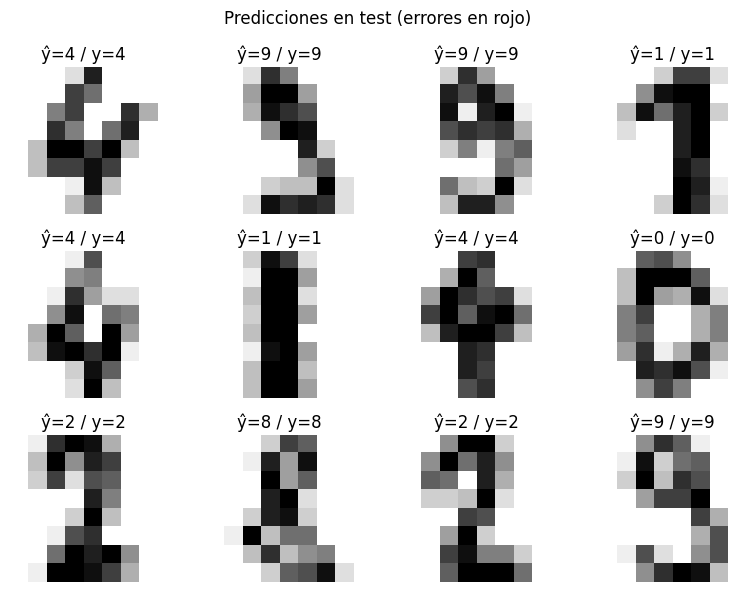

In [33]:
# Mostrar 12 ejemplos con su predicción (marcar errores en rojo)
idx = np.random.choice(len(X_test_s), size=12, replace=False)
fig, axes = plt.subplots(3, 4, figsize=(8,6))
for ax, i in zip(axes.ravel(), idx):
    img = X_test[i].reshape(8,8)  # sin escalar para visualizar
    ax.imshow(img, cmap="gray_r")
    ax.axis("off")
    pred = y_pred[i]
    true = y_test[i]
    color = "red" if pred != true else "black"
    ax.set_title(f"ŷ={pred} / y={true}", color=color)
plt.suptitle("Predicciones en test (errores en rojo)")
plt.tight_layout(); plt.show()
